# NP

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import time
from neuralprophet import NeuralProphet, set_log_level, save, load, set_random_seed
from config import *
import pickle
import torch
import contextlib
from dataloading_helpers import electricity_dataloader
import pandas as pd
set_log_level("ERROR")
set_random_seed(111)

## 1. Electricity dataset

In [13]:
# run this for using googles normalization

train, val, test = electricity_dataloader.create_electricity_timeseries_np()

train['date'] =  pd.to_datetime(train['date'], format='%Y-%m-%d %H:%M:%S.%f')
train.rename(columns={"power_usage": "y", "date": "ds", "id": "ID"}, inplace = True)

test['date'] =  pd.to_datetime(test['date'], format='%Y-%m-%d %H:%M:%S.%f')
test.rename(columns={"power_usage": "y", "date": "ds", "id": "ID"}, inplace = True)
test = test[test["ds"] >= "2014-09-01"]


val['date'] =  pd.to_datetime(val['date'], format='%Y-%m-%d %H:%M:%S.%f')
val.rename(columns={"power_usage": "y", "date": "ds", "id": "ID"}, inplace = True)

# specify input variables
input_columns = ["ID", "y","ds"]                                  # index + target + datetime

future_regressors = []
lagged_regressors = ['hour', 'day', 'day_of_week', 'month'] 
events = [] 

df_train = train[input_columns + lagged_regressors]    # with regressors
test = test[input_columns + lagged_regressors] 
df_val = val[input_columns + lagged_regressors] 

#num_id = 1
#df_train = df_train[df_train.ID.isin(df_train.ID.unique()[:num_id])]
#test = test[test.ID.isin(test.ID.unique()[:num_id])]
#df_val = df_val[df_val.ID.isin(df_val.ID.unique()[:num_id])]


model = NeuralProphet(
        growth = "off",                    # no trend
        trend_global_local = "global",
        season_global_local = "global",                
        n_lags = 6*24,                      # autoregressor on last 24h x 7 days
        n_forecasts = 24,                   # forecast horizon
        yearly_seasonality = True,
        weekly_seasonality = True,
        daily_seasonality = True,
        learning_rate = 0.05,
        loss_func = "MSE",
        quantiles = [0.1, 0.5, 0.9],
        normalize="off"
    )
    
model = model.highlight_nth_step_ahead_of_each_forecast(step_number = model.n_forecasts)
model = model.add_lagged_regressor(names = lagged_regressors) 


INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (144)


In [3]:
# run this for using build in normalizer
csv_file = CONFIG_DICT["datasets"]["electricity"] / "LD2011_2014.csv"
electricity = pd.read_csv(csv_file, index_col=0)

electricity['date'] =  pd.to_datetime(electricity['date'], format='%Y-%m-%d %H:%M:%S.%f')
electricity.rename(columns={"power_usage": "y", "date": "ds", "id": "ID"}, inplace = True)

test_boundary=1339
index = electricity['days_from_start']

train = electricity.loc[(index >= 1100) & (index < test_boundary)]
test = electricity.loc[index >= test_boundary]

# specify input variables
input_columns = ["ID", "y","ds"]                                  # index + target + datetime

future_regressors = []
lagged_regressors = ['hour', 'day', 'day_of_week', 'month'] 
events = [] 

train = train[input_columns + lagged_regressors]    # with regressors
test = test[input_columns + lagged_regressors] 

model = NeuralProphet(
        growth = "off",                    # no trend
        trend_global_local = "global",
        season_global_local = "global",                
        n_lags = 6*24,                      # autoregressor on last 24h x 7 days
        n_forecasts = 24,                   # forecast horizon
        yearly_seasonality = True,
        weekly_seasonality = True,
        daily_seasonality = True,
        learning_rate = 0.05,
        loss_func = "MSE",
        quantiles = [0.1, 0.5, 0.9],
    )
    
model = model.highlight_nth_step_ahead_of_each_forecast(step_number = model.n_forecasts)
model = model.add_lagged_regressor(names = lagged_regressors)   # , only_last_value=True)

def split_train_test(df, model, num_id=0, valid_p=0.2):
    '''
    to ran only on part of data (for first # id) :   specify parameter num_id, e.g. num_id=5 (for first 5 ids)
    '''
    if num_id==0:
        df = df
    else:
        df = df[df.ID.isin(df.ID.unique()[:num_id])]
    
    df_train, df_test = model.split_df( 
        df,    
        freq='H',
        valid_p = valid_p,         
        local_split = True
    )
    
    return df_train, df_test

df_train, df_val = split_train_test(train, model, num_id=1)

## Model

In [8]:
metrics = model.fit(
        df = df_train, 
        validation_df = df_val,
        freq='H', 
        progress="print",
        num_workers = 10,
        #early_stopping=True,
        learning_rate=0.1,
        epochs=1,
        batch_size=64
)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.981% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [9]:
forecast = model.predict(test)
forecast

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.405% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.479% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 80it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

,ds,y,ID,yhat1,yhat2,yhat3,yhat4,yhat5,yhat6,yhat7,...,lagged_regressor_month19,lagged_regressor_month20,lagged_regressor_month21,lagged_regressor_month22,lagged_regressor_month23,lagged_regressor_month24,trend,season_yearly,season_weekly,season_daily
0,2014-09-01 00:00:00,3.160683,MT_001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-09-01 01:00:00,3.237144,MT_001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-09-01 02:00:00,3.160683,MT_001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-09-01 03:00:00,3.237144,MT_001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-09-01 04:00:00,3.160683,MT_001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2014-09-07 19:00:00,3.237144,MT_001,4.738852,1.905624,3.340252,-0.243360,5.814107,5.061140,2.505650,...,1.562181,0.831303,NaN,NaN,NaN,NaN,-0.632972,-0.238646,-0.343705,-0.048053
164,2014-09-07 20:00:00,0.025749,MT_001,4.215585,0.877230,3.430737,0.896267,6.543316,5.724873,1.865790,...,1.562181,0.831303,2.101289,NaN,NaN,NaN,-0.632972,-0.241636,-0.333334,-0.078888
165,2014-09-07 21:00:00,1.325600,MT_001,1.751271,2.118034,3.716104,3.092473,5.739073,4.190723,3.205987,...,1.562181,0.831303,2.101289,1.21662,NaN,NaN,-0.632972,-0.244626,-0.320806,-0.093928
166,2014-09-07 22:00:00,3.237144,MT_001,2.450511,1.406710,4.987397,1.948030,4.998906,5.622784,2.716744,...,1.562181,0.831303,2.101289,1.21662,1.448137,NaN,-0.632972,-0.247616,-0.306249,-0.171188


In [12]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Columns: 199 entries, ds to season_daily
dtypes: datetime64[ns](1), float64(197), object(1)
memory usage: 261.3+ KB


In [40]:
final_forecast = forecast.iloc[167::1, :]
final_forecast

,ds,y,ID,yhat1,yhat2,yhat3,yhat4,yhat5,yhat6,yhat7,...,lagged_regressor_month19,lagged_regressor_month20,lagged_regressor_month21,lagged_regressor_month22,lagged_regressor_month23,lagged_regressor_month24,trend,season_yearly,season_weekly,season_daily
743,2014-08-31 23:00:00,3.237144,MT_001,2.449459,2.118088,2.980648,1.586023,3.948090,3.034333,2.559239,...,0.983888,0.833647,0.939968,0.930088,0.954291,0.782366,0.53312,-0.074022,0.191205,0.020388
1460,2014-08-30 20:00:00,2.500518,MT_002,3.023546,1.828527,2.788059,1.941206,2.140305,1.255787,2.101570,...,0.983888,0.833647,0.939968,0.930088,0.954291,0.782366,0.53312,-0.058030,-0.321641,0.177218


In [41]:
forecast.to_csv("small_forecast.csv")

In [10]:
final_forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 167 to 1343
Columns: 199 entries, ds to season_daily
dtypes: datetime64[ns](1), float64(197), object(1)
memory usage: 12.6+ KB


In [15]:
#test_1 = test[test["ID"] == "MT_001"]
forecast = model.predict(test, decompose=True)
forecast
test.info()

Predicting: 80it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

<class 'pandas.core.frame.DataFrame'>
Int64Index: 744 entries, 22632 to 23375
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ID           744 non-null    object        
 1   y            744 non-null    float64       
 2   ds           744 non-null    datetime64[ns]
 3   hour         744 non-null    float64       
 4   day          744 non-null    float64       
 5   day_of_week  744 non-null    float64       
 6   month        744 non-null    float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 46.5+ KB


In [29]:
#test_2 = test[(test["ID"] == "MT_001") or (test["ID"] == "MT_002")]
test_2 = test[test.ID.isin(test.ID.unique()[:5])]
test_2

,ID,y,ds,hour,day,day_of_week,month
23376,MT_001,16.180203,2014-09-01 00:00:00,0,1,0,9
23377,MT_001,16.497462,2014-09-01 01:00:00,1,1,0,9
23378,MT_001,16.180203,2014-09-01 02:00:00,2,1,0,9
23379,MT_001,16.497462,2014-09-01 03:00:00,3,1,0,9
23380,MT_001,16.180203,2014-09-01 04:00:00,4,1,0,9
...,...,...,...,...,...,...,...
260284,MT_010,28.225806,2014-09-07 19:00:00,19,7,6,9
260285,MT_010,39.784946,2014-09-07 20:00:00,20,7,6,9
260286,MT_010,52.956989,2014-09-07 21:00:00,21,7,6,9
260287,MT_010,49.193548,2014-09-07 22:00:00,22,7,6,9


In [49]:
import neuralprophet

regressor = neuralprophet.df_utils.create_dict_for_events_or_regressors(df_train)

#data_params = neuralprophet.df_utils.init_data_params(df_train, normalize="standardize", config_lagged_regressors=['hour', 'day', 'day_of_week', 'month'] )

#train_norm = neuralprophet.df_utils.normalize(df_train, data_params)
#train_norm
#data_params
regressor

TypeError: create_dict_for_events_or_regressors() missing 2 required positional arguments: 'other_df' and 'other_df_name'

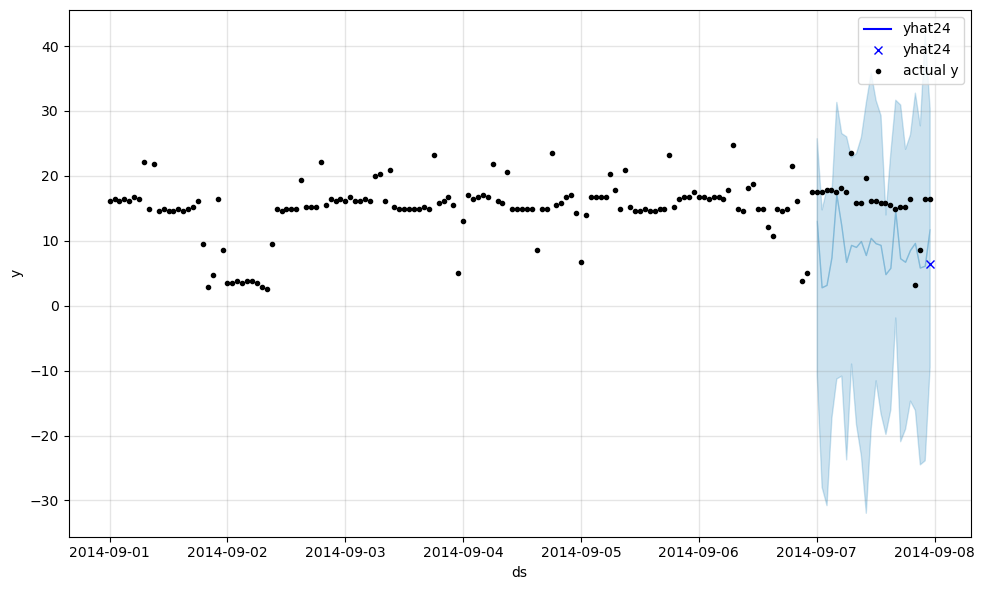

In [20]:
fig = model.plot(forecast[forecast["ID"] == "MT_001"])
fig = model.plot_components(forecast[forecast["ID"] == 'MT_001'])


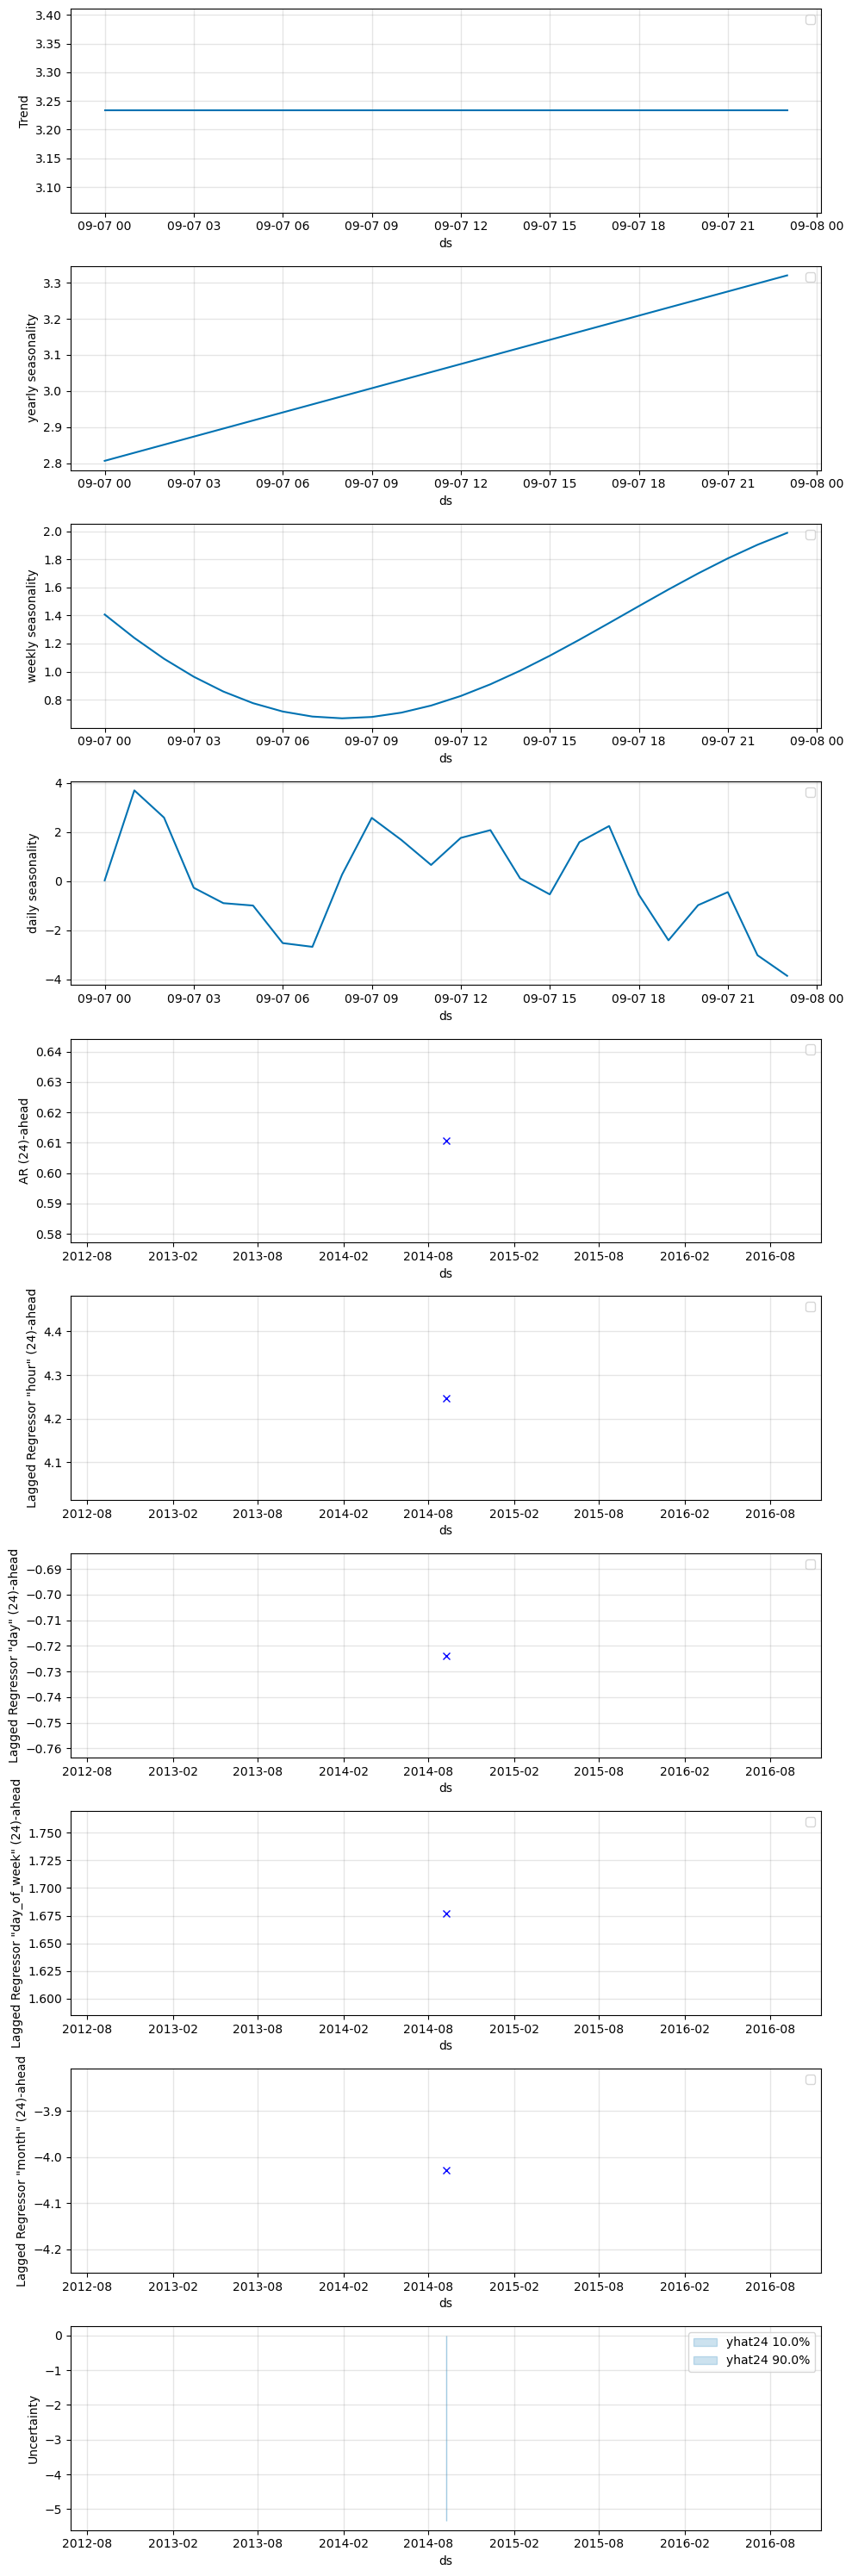

In [22]:
fig = model.plot_components(forecast[forecast["ID"] == 'MT_001'])

#fig = m.plot_components(forecast[-8 * 24 :])   #print only for last 7 days

In [32]:
from dataloading_helpers import electricity_dataloader
import pmdarima as Arima
from pmdarima.arima.stationarity import ADFTest
from pmdarima.arima.utils import ndiffs
import pandas as pd
from pmdarima.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima.metrics import smape
from statistics import mean, median
# code for whole arima training
# load data
train_data, test_data, val_data = electricity_dataloader.create_electricity_timeseries_np()

predictions_path = CONFIG_DICT["models"]["electricity"] / "arima" / "global_preds_arima.csv"

try:
    global_preds_arima = pd.read_csv(predictions_path) 
except:
    print("No predictions available.")
    global_preds_arima = pd.DataFrame(columns=["id_nr", "forecasts", "test_data_id_predict_y", "global_confidence_upper", "global_confidence_lower"])

    
# iterate over all ids
for id_string in test_data.categorical_id.unique():
    start_time = time.time()
    
    # skip over ids that have predictions present, id=15 throws "LinAlgError: LU decomposition error."
    if int(id_string) in global_preds_arima["id_nr"].values or id_string=="15":
        continue
        
    # select one id, define x/y train dataframe and fit model
    train_data_id = train_data[train_data["categorical_id"] == id_string]
    train_data_id = train_data_id[int(len(train_data_id) * 0.8) :]
    train_data_id_y = train_data_id["power_usage"]
    train_data_id_x = train_data[["categorical_hour", "time_idx", "categorical_day_of_week"]].copy()

    model = Arima.auto_arima(train_data_id_y, exogenous=train_data_id_x, stepwise=True, seasonal=True, m=24, maxiter=5)


    # refit model on test_data and predict on last 24 timesteps
    test_data_id = test_data[test_data["categorical_id"] == id_string]
    train_limit = (len(test_data_id)) - 24
    test_data_id_update, test_data_id_predict = train_test_split(test_data_id, train_size=train_limit)

    test_data_id_update_y = test_data_id_update["power_usage"]
    test_data_id_predict_y = test_data_id_predict["power_usage"]

    test_data_id_update_x = test_data_id_update[["categorical_hour", "time_idx", "categorical_day_of_week"]].copy()
    test_data_id_predict_x = test_data_id_predict[["categorical_hour", "time_idx", "categorical_day_of_week"]].copy()

    model.update(test_data_id_update_y, test_data_id_update_x)

    # make your forecasts
    forecasts, confidence = model.predict(test_data_id_predict_y.shape[0], return_conf_int=True, exogenous=test_data_id_predict_x, alpha=0.1)
    
    end_time = time.time()
    print(f"Mean absolute error for id {id_string} is: {(mean_absolute_error(test_data_id_predict_y, forecasts)):.3f}. This iteration took: {((end_time-start_time)/60):.2f} minutes.")

    id_list = [id_string] * 24
    
    # join relevent values to dataframe
    output = pd.DataFrame({
                        'id_nr': id_list,
                        'forecasts': forecasts,
                        'test_data_id_predict_y': test_data_id_predict_y,
                        'global_confidence_upper': confidence[:,1],
                        'global_confidence_lower': confidence[:,0]
                        })
    
    # join to present predictions
    global_preds_arima = pd.concat([global_preds_arima, output], axis=0)

    global_preds_arima.to_csv(predictions_path, index=False)
        
print(f"Mean absolute error: {mean_absolute_error(global_preds_arima.forecasts , global_preds_arima.test_data_id_predict_y)}")

Mean absolute error for id 311 is: 0.062. This iteration took: 3.69 minutes.
Mean absolute error for id 312 is: 0.173. This iteration took: 5.86 minutes.
Mean absolute error for id 313 is: 0.110. This iteration took: 2.24 minutes.
Mean absolute error for id 314 is: 0.136. This iteration took: 3.81 minutes.
Mean absolute error for id 315 is: 0.070. This iteration took: 3.54 minutes.
Mean absolute error for id 316 is: 0.093. This iteration took: 4.87 minutes.
Mean absolute error for id 317 is: 0.118. This iteration took: 2.31 minutes.
Mean absolute error for id 318 is: 0.194. This iteration took: 3.58 minutes.
Mean absolute error for id 319 is: 0.360. This iteration took: 1.05 minutes.
Mean absolute error for id 320 is: 0.158. This iteration took: 1.19 minutes.
Mean absolute error for id 321 is: 0.094. This iteration took: 2.83 minutes.
Mean absolute error for id 322 is: 0.138. This iteration took: 3.65 minutes.
Mean absolute error for id 323 is: 0.183. This iteration took: 6.67 minutes.

KeyboardInterrupt: 

In [ ]:
print("Importing modules.")

import time
import pandas as pd
from dataloading_helpers import electricity_dataloader
from config import *
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pmdarima as Arima
from dataloading_helpers import electricity_dataloader
from pmdarima.arima.stationarity import ADFTest
from pmdarima.arima.utils import ndiffs
import pandas as pd
from pmdarima.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima.metrics import smape
from statistics import mean, median


print("Loading dataset.")
train_data, val_data, test_data = electricity_dataloader.create_electricity_timeseries_np()
test_data = test_data[test_data["date"] >= "2014-09-07"]

train_data = pd.concat([train_data, val_data])
predictions_path = CONFIG_DICT["models"]["electricity"] / "arima" / "global_preds_arima.csv"

try:
    global_preds_arima = pd.read_csv(predictions_path) 
except:
    print("No predictions available.")
    global_preds_arima = pd.DataFrame(columns=["id_nr", "forecasts", "test_data_id_predict_y", "global_confidence_upper", "global_confidence_lower"])


# iterate over all ids
for id_string in test_data.categorical_id.unique():
    start_time = time.time()

    # skip over ids that have predictions present, id=15 throws "LinAlgError: LU decomposition error."
    if int(id_string) in global_preds_arima["id_nr"].values or id_string=="15":
        continue

    # select one id, define x/y train dataframe and fit model
    train_data_id = val_data[val_data["categorical_id"] == id_string]
    train_data_id = train_data_id[int(len(train_data_id) * 0.4) :]
    train_data_id_y = train_data_id["power_usage"]
    train_data_id_x = train_data[["categorical_hour", "time_idx", "categorical_day_of_week"]].copy()

    model = Arima.auto_arima(train_data_id_y, exogenous=train_data_id_x, stepwise=True, seasonal=True, m=24, maxiter=10)
          
    test_data_id = test_data[test_data["categorical_id"] == id_string]
    test_data_id_y = test_data_id["power_usage"]

    test_data_id_x = test_data_id[["categorical_hour", "time_idx", "categorical_day_of_week"]].copy()

    # make your forecasts
    forecasts, confidence = model.predict(test_data_id_y.shape[0], return_conf_int=True, exogenous=test_data_id_x, alpha=0.1)

    end_time = time.time()
    print(f"Mean absolute error for id {id_string} is: {(mean_absolute_error(test_data_id_y, forecasts)):.3f}. This iteration took: {((end_time-start_time)/60):.2f} minutes.")

    id_list = [id_string] * 24


    # join relevent values to dataframe
    output = pd.DataFrame({
                          'id_nr': id_list,
                          'forecasts': forecasts.values,
                          'test_data_id_predict_y': test_data_id_y.values,
                          'global_confidence_upper': confidence[:,1],
                          'global_confidence_lower': confidence[:,0]
                          })

    # join to present predictions
    global_preds_arima = pd.concat([global_preds_arima, output], axis=0)

    global_preds_arima.to_csv(predictions_path, index=False)

print(f"Mean absolute error: {mean_absolute_error(global_preds_arima.forecasts , global_preds_arima.test_data_id_predict_y)}")

In [ ]:
id_list,
#forecasts,
#test_data_id_y,
#confidence[:,1],
#confidence[:,0]

In [53]:
test_data_id_y.reset_index()

,index,power_usage
0,23520,3.466530
1,23521,3.466530
2,23522,3.542991
3,23523,3.542991
4,23524,3.466530
5,23525,3.619453
6,23526,3.466530
7,23527,4.919304
8,23528,3.084221
9,23529,3.084221
